# Tuning hyper-parameters for explained_variance

{'alpha': 0.01, 'kernel': DotProduct(sigma_0=0.1)}
# Tuning hyper-parameters for r2

{'alpha': 0.01, 'kernel': DotProduct(sigma_0=10)}


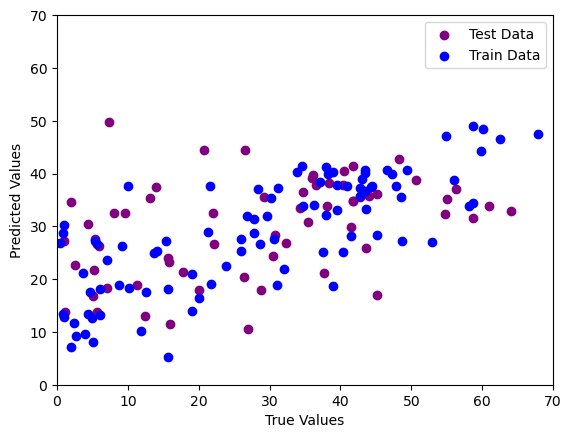

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic as RQ, WhiteKernel, ExpSineSquared as Exp, DotProduct as Lin  
from sklearn.preprocessing import MaxAbsScaler,StandardScaler,Normalizer
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

data=pd.read_csv('Important_features_npvol_3.csv', sep=";")

data_ar=np.array(data)
data.drop('Glass_ID', axis=1, inplace=True)
# features_only=np.zeros([154,8])
# for i in range(8):
#     for j in range (154):
#         features_only[j,i] = data_ar[j,i+4]
        
features_only = pd.DataFrame(data)
#
features_only.columns = data.columns

features_only = features_only.drop(['Nepheline Volume', 'Label'], axis=1)


column_names = list(features_only.columns)  

sc = StandardScaler()
mole_fracs_std = sc.fit_transform(features_only)

mole_fracs_std_df = pd.DataFrame(mole_fracs_std, columns=column_names)

df=pd.DataFrame([])

#df['CharDev5']= mole_fracs_std_df['CharDev5']
df['B2O3']=mole_fracs_std_df['B2O3']
df['Al2O3']=mole_fracs_std_df['Al2O3']
#df['Fe2O3']= mole_fracs_std_df['Fe2O3']
df['SiO2']= mole_fracs_std_df['SiO2']
df['P2O5']= mole_fracs_std_df['P2O5']

#df['Fe/(Fe+Al)']=mole_fracs_std_df['Fe_(Fe+Al)']
df['Si/(Si+Al)'] = mole_fracs_std_df['Si_(Si+Al)']

df['Npvol'] = data['Npvol']
df['Label'] = data['Label']
target =df['Label'].copy()
attr3 = df.drop(['Label'], axis=1)
npvol =df['Npvol'].copy()
attr4 = attr3.drop(['Npvol'], axis=1) #attr4te npvol yok
attr = np.array(attr3) #npvol var 

target = np.array(target)

# from sklearn.model_selection import StratifiedShuffleSplit

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
# sss.split(attr3, target)
# for i, (train_index, test_index) in enumerate(sss.split(attr3,target)):
#      print(f"Fold {i}:")
#      print(f"  Train: index={train_index}")
#      print(f"  Test:  index={test_index}")



# corrmat =df.corr()
# top_corr_features = corrmat.index
# plt.figure(figsize=(20,20))
# g= sns.heatmap(df[top_corr_features].corr(), annot= True,cmap="RdYlGn")

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    attr, target, test_size=0.4, random_state=42,stratify=target)

X_train=pd.DataFrame(X_train)
X_train.columns=attr3.columns
npvol_train =X_train['Npvol'].copy()
X_train2 = X_train.drop(['Npvol'], axis=1) 
y_train2=npvol_train

X_test=pd.DataFrame(X_test)
X_test.columns=attr3.columns
npvol_test =X_test['Npvol'].copy()
X_test2 = X_test.drop(['Npvol'], axis=1) 
y_test2=npvol_test


# df['Npvol'] = npvol

#GRID SEARCH START

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.exceptions import ConvergenceWarning
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


param_grid = [{
    "alpha":  [1e-2, 1e-3],
    "kernel": [RBF(length_scale=l) for l in np.logspace(-3, 3, 4)]
}, {
    "alpha":  [1e-2, 1e-3],
    "kernel": [DotProduct(sigma_0=sigma_0) for sigma_0 in np.logspace(-3, 3, 4)]
}]

# Scores for regression
scores = ['explained_variance', 'r2']

gp = GaussianProcessRegressor(n_restarts_optimizer=100, alpha=0.6, normalize_y=True, )
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(estimator=gp, param_grid=param_grid, cv=4, scoring='%s' % score)
    clf.fit(X_train, y_train)
    print(clf.best_params_)

gp.fit(X_train2,y_train2)

y_pred_train, std = gp.predict(X_train2, return_std=True)
y_pred_test, std = gp.predict(X_test2, return_std=True)

plt.scatter(y_test2, y_pred_test, label='Test Data', c='purple')
plt.scatter(y_train2, y_pred_train, label='Train Data',c='blue')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim(0, 70)  
plt.ylim(0, 70) 

plt.legend()
plt.show()


MAE_test = (np.abs(y_pred_test-y_test)).mean()
MAE_train = (np.abs(y_pred_train-y_train)).mean()


